## Sentiment Classifier ##
Methods herein are adapted for our use from an article by Robyn Speer, http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

Many methods, including the dataset used for positive and negative word training, is taken from the paper: https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf



## Files needed to run this Notebook ##
'data/glove.42B.300d.txt'
'data/negative-words.txt'
'data/positive-words.txt'
'working_data/dataset2_crowdtruth_working.csv'

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from scipy import stats

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [2]:
# load the Glove 42B 300 dimensional embeddings with vocab of 1.9 million words
# download from https://nlp.stanford.edu/projects/glove/

def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

In [13]:
embeddings.loc['and']

0     -0.096110
1     -0.257880
2     -0.358600
3     -0.328870
4      0.579500
5     -0.517740
6     -4.158200
7     -0.113710
8     -0.108480
9     -0.488850
10     0.199310
11    -0.105400
12    -0.438250
13    -0.344830
14    -0.450520
15    -0.348640
16    -0.458000
17    -0.815540
18     0.220060
19     0.202540
20    -0.109540
21     0.125200
22    -0.541170
23     0.347310
24    -0.099998
25    -0.018998
26    -0.142770
27    -0.424810
28    -0.009409
29    -0.431550
         ...   
270   -0.167800
271   -0.444380
272   -0.730510
273    0.109570
274    0.131220
275    0.085623
276    0.125040
277   -0.403370
278    0.041765
279   -0.275740
280    0.062513
281    0.051093
282    0.399260
283    0.111490
284   -0.056462
285    0.268090
286   -0.395690
287    0.310330
288   -0.049750
289   -0.331390
290    0.477810
291   -0.021213
292   -0.212360
293    0.423740
294    0.140830
295    0.067498
296   -0.126750
297   -0.370300
298   -0.092774
299    0.390580
Name: and, Length: 300, 

In [46]:
embeddings.loc["didn't"]

0     -0.097326
1      0.136320
2      0.041960
3      0.045057
4     -0.305260
5      0.210370
6      0.545770
7     -0.374170
8     -0.020192
9     -0.185770
10     0.453010
11     0.331960
12     0.293970
13    -0.522320
14    -0.067976
15    -0.140280
16     0.176110
17    -0.131520
18     0.010525
19    -0.299680
20     0.333610
21    -0.494130
22     0.306550
23    -0.091483
24     0.035578
25     0.394330
26    -0.383080
27    -0.173110
28     0.058693
29     0.014521
         ...   
270    0.590480
271   -0.472410
272    0.042030
273   -0.076867
274    0.445140
275   -0.148960
276   -0.221460
277    0.052473
278   -0.042607
279   -0.071864
280   -0.242170
281    0.388730
282   -0.061173
283   -0.240360
284    0.014724
285    0.258120
286   -0.192650
287    0.039143
288    0.057558
289   -0.232320
290    0.034761
291   -0.079114
292    0.181400
293   -0.005795
294    0.228070
295    0.099392
296    0.217030
297   -0.284840
298    0.008674
299    0.234890
Name: didn't, Length: 30

In [4]:
# Load the dataset of positive and negative word examples, 
# download and uncompress the RAR file of 6800 words from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon

def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')


In [5]:
print("Number of positive words:",len(pos_words))
print("Number of negative words:",len(neg_words))

Number of positive words: 2006
Number of negative words: 4783


In [6]:
# look up embeddings of the pos and neg words, removing unknown words in the embedding matrix
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
print("Number of positive vectors:",len(pos_vectors))
print("Number of negative vectors:",len(neg_vectors))

Number of positive vectors: 1977
Number of negative vectors: 4652


In [9]:
# concatenate separate arrays for the embeddings (vectors, inputs), 
# sentiment targets (-1 for neg sentiment words, +1 for pos),
# and the original words (labels)

vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [10]:
vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
abound,-0.520520,-0.067637,0.29122,-0.44463,0.18443,0.383680,-1.54430,-0.911500,-0.231870,-0.124110,...,0.52301,0.26247,0.607280,-0.200940,0.13338,-0.385320,-0.080902,-0.11752,-0.313240,0.44835
abounds,-0.413170,0.125230,0.33134,-0.14340,0.50204,0.049104,-0.36833,-0.516770,-0.087633,0.011226,...,0.57082,0.25962,-0.047559,-0.314910,0.44567,-0.379170,0.099762,-0.10958,-0.046536,0.29307
abundance,0.171640,-0.004225,0.04697,-0.10938,-0.47105,-0.111360,-2.44600,0.043131,0.039437,-0.231090,...,0.25006,0.10919,0.177710,-0.026047,0.45477,-0.249730,-0.265330,-0.32453,0.152320,0.43615
abundant,-0.033792,-0.052977,0.17889,-0.21864,-0.24726,-0.139120,-2.29690,0.158910,-0.128300,-0.268260,...,0.35116,-0.18413,0.030269,-0.033167,0.36837,-0.278680,-0.136050,-0.40893,-0.031317,0.24128
accessable,0.027203,-0.203950,0.31187,-0.34178,0.09668,0.131390,-0.71731,0.065835,-0.364050,0.304130,...,-0.14508,-0.11289,0.084059,-0.207890,-0.14800,0.061543,0.015907,-0.33746,-0.038422,-0.42917


In [11]:
# split the vectors into train test split
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [12]:
train_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
virulent,0.250540,-0.242920,-0.406390,-0.11377,0.379710,-0.022969,-0.98700,1.00180,-0.237070,0.278510,...,-0.17251,-0.363070,-0.222040,-0.45320,-0.43222,-0.118780,-0.092416,-0.26962,-0.33952,-0.056659
successful,0.134780,1.100400,-0.524150,0.29583,-0.078742,-0.060608,-3.36930,0.29168,-0.007743,0.250670,...,0.22836,-0.294260,0.030031,-0.17113,-0.14046,0.068085,0.203010,0.14828,0.13710,-0.090951
adoringly,-0.288710,-0.005282,0.061099,0.10700,-0.229140,-0.152780,-0.20631,-0.48046,-0.136430,-0.025725,...,0.01984,0.249420,0.122010,-0.15978,0.73528,0.094661,-0.593000,0.24046,0.13308,-0.251720
divine,-0.293780,-0.293590,0.396610,-0.22584,-0.631230,0.399520,-2.46710,0.12340,0.227550,-0.048812,...,-0.40137,0.070193,0.205250,-0.17218,0.51357,0.171620,-0.451250,-0.40289,-0.34613,0.049481
rectification,0.031418,0.286450,-0.399180,-0.48131,0.168350,-0.240990,-0.86958,0.92432,-0.218650,0.069423,...,-0.59124,-0.046035,0.060123,0.40280,0.21916,0.177720,0.048238,-0.11681,-0.60028,-0.303830


In [13]:
# run a stochastic gradient descent classifier using SciKitLearn
model = SGDClassifier(loss='log', random_state=0, n_iter=100)
model.fit(train_vectors, train_targets)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=100,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
# 95% accuracy achieved on our initial test set
accuracy_score(model.predict(test_vectors), test_targets)

0.9502262443438914

In [15]:
# display log odds probabilities for a subset of words

def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[300:310]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,sentiment
bothersome,-15.673281
tingle,-1.371096
discontinuous,-7.616859
mastery,6.777180
unrelentingly,-4.456836
endorsed,7.161231
flare,-5.802420
impatient,-8.896710
abused,-11.761943
madden,-2.693171


In [52]:
words_to_sentiment(test_labels).ix[400:500]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,sentiment
impetuously,-2.797589
dragoon,-0.875473
felonious,-4.704045
hospitable,9.543061
flabbergasted,-2.016795
epidemic,-11.160551
pest,-0.240723
sagely,2.150888
flees,-7.363441
irreparable,-7.754882


In [14]:
# how to index out given words to check if they are in the training set
train_vectors.loc["happy"]

0     -0.066124
1     -0.200290
2     -0.221590
3      0.050562
4      0.414830
5      0.082958
6     -3.028100
7     -0.483540
8      0.237090
9     -1.014000
10     0.295420
11     0.007623
12     0.039743
13    -0.069646
14    -0.353320
15     0.084045
16     0.061455
17    -0.152980
18    -0.036661
19     0.025708
20     0.058447
21    -0.205920
22     0.145400
23     0.237910
24    -0.427250
25     0.004527
26     0.339800
27     0.140430
28     0.543280
29     0.552180
         ...   
270   -0.103480
271    0.126510
272   -0.448950
273   -0.177340
274   -0.501100
275    0.166950
276   -0.241360
277    0.013578
278    0.065264
279   -0.158970
280    0.150920
281   -0.028688
282   -0.389640
283   -0.051028
284    0.526230
285    0.582460
286   -0.166030
287    0.649210
288   -0.319870
289   -0.425260
290   -0.291620
291    0.190030
292   -0.078787
293    0.073229
294    0.194700
295    0.132580
296   -0.058924
297    0.377660
298    0.569440
299   -0.351040
Name: happy, Length: 300

In [17]:
# tokenize by simply separating words and lowercasing them, outputting the average log odds for a sample of text

import re
TOKEN_RE = re.compile(r"\w.*?\b")

# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    #print(tokens)
    sentiments = words_to_sentiment(tokens)
    phrase_length = len(tokens)
    #print(sentiments)
    return sentiments['sentiment'].mean()

In [18]:
def doc_length(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    #print(tokens)
    phrase_length = len(tokens)
    #print(sentiments)
    return phrase_length

## EDA on the deduped dataset ##

In [19]:
# input CSV of jokes into a dataframe
#jokes = pd.read_csv('data/dataset2_crowdtruth_17k.csv')
jokes = pd.read_csv('working_data/dataset2_crowdtruth_working.csv')

In [20]:
jokes["sentiment"] = jokes['text'].map(text_to_sentiment)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [21]:
jokes["doc_length"] = jokes['text'].map(doc_length)

In [22]:
len(jokes['text'])

10868

In [26]:
#pd.options.display.max_colwidth = 1000
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
jokes[1300:1320]

,text,funny,not_funny,sentiment,doc_length
1300,opec sees further action if output 'freeze' deal holds,0,1,-0.404489,9
1301,the main plot follows two terminally ill men on their road trip with a wish list of things to do before they `` kick the bucket . '',0,1,0.118106,25
1302,'midnight special' film at berlin takes sci-fi look at parenting,0,1,2.047921,11
1303,a timeline of gm's faulty ignition switch:,0,1,-1.593997,8
1304,`` say my name '' is hit song by american r&b group destiny 's child.,0,1,0.876754,14
1305,turkey turns off independent tv channel on 'terrorist' charge,0,1,0.080747,9
1306,by 1996 only a rough quarter of us households consisted of married couples with children.,0,1,2.162607,15
1307,london mayor boris johnson says backs british exit from eu,0,1,0.832033,10
1308,"tokyo, okinawa at odds as u.s. airbase city votes for mayor",0,1,1.467769,12
1309,more than 60 people killed in suicide bombs in nigeria: officials,0,1,-1.048922,11


In [30]:
#make two dataframes for simplicity, one for each class of jokes
funny = jokes[(jokes['funny'] == 1)]
not_funny = jokes[(jokes['funny'] == 0)]

print(len(funny),"funny-labeled jokes comprise","{:.1f}".format(len(funny)/len(jokes)*100),"% of the",len(jokes),"row dataset2_crowdtruth_working.csv")



5434 funny-labeled jokes comprise 50.0 % of the 10868 row dataset2_crowdtruth_working.csv


Mean average of doc_length for Dataset 2 14.54
Mean average of doc_length for funny class 16.03
Mean average of doc_length for not funny class 13.06


Standard dev of length of all docs: 6.91
Standard dev of length of funny docs: 6.19
Standard dev of length of not funny docs: 7.26


Test for homogeneity of variance of document length between the two classes:
LeveneResult(statistic=0.8647883333384121, pvalue=0.3524228290901634)


With similar variance, do a two sided t-test of similar distributions:
Ttest_indResult(statistic=22.92154930407574, pvalue=1.3643934226621523e-113)




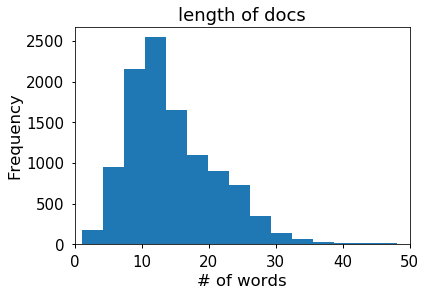

In [53]:
# check that the length of the jokes is not affecting the variance of the sentiment score
#len(jokes.iloc[110,0])

jokes['doc_length'].plot(kind="hist", title="length of docs", bins=50)
plt.xlabel("# of words")
plt.xlim(0, 50)
plt.savefig('length of words')

#print("{:.2f}".format(jokes['doc_length'].mean()))
print("Mean average of doc_length for Dataset 2", "{:.2f}".format(jokes['doc_length'].mean()))
print("Mean average of doc_length for funny class", "{:.2f}".format(funny['doc_length'].mean()))
print("Mean average of doc_length for not funny class", "{:.2f}".format(not_funny['doc_length'].mean()))
print("\n")
print("Standard dev of length of all docs:", "{:.2f}".format(jokes["doc_length"].std()))
print("Standard dev of length of funny docs:", "{:.2f}".format(funny["doc_length"].std()))
print("Standard dev of length of not funny docs:", "{:.2f}".format(not_funny["doc_length"].std()))
print("\n")
print("Test for homogeneity of variance of document length between the two classes:")
print(stats.levene(funny['doc_length'], not_funny['doc_length']))
print("\n")
print("With similar variance, do a two sided t-test of similar distributions:")
print(stats.ttest_ind(funny['doc_length'], not_funny['doc_length'],equal_var = True))
print("\n")




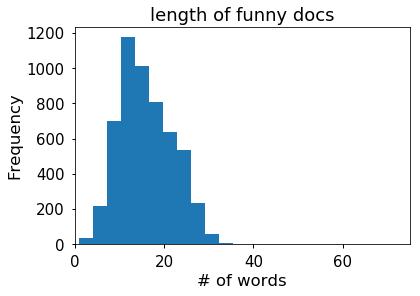

In [37]:
funny['doc_length'].plot(kind="hist", title="length of funny docs", bins=50)
plt.xlabel("# of words")
plt.xlim(0, 75)
plt.savefig('length of words')

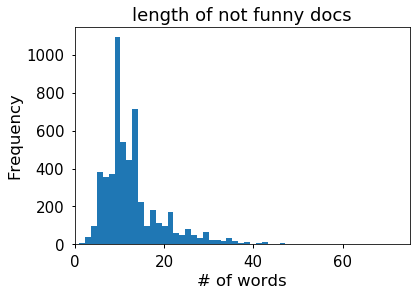

In [38]:
not_funny['doc_length'].plot(kind="hist", title="length of not funny docs", bins=50)
plt.xlabel("# of words")
plt.xlim(0, 75)
plt.savefig('length of words')

Knowing that the doc lengths are moderately different, see if length impacts sentiment:


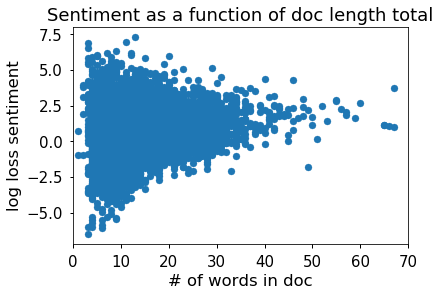

In [39]:
print("Knowing that the doc lengths are moderately different, see if length impacts sentiment:")
plt.scatter(jokes['doc_length'], jokes['sentiment'])
plt.xlabel("# of words in doc")
plt.ylabel("log loss sentiment")
plt.xlim(0, 70)
plt.title("Sentiment as a function of doc length total")
plt.savefig('sentiment vs length')

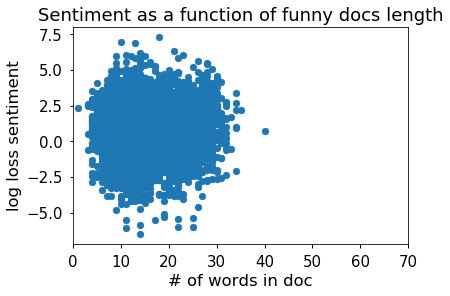

In [40]:

plt.scatter(funny['doc_length'], not_funny['sentiment'])
plt.xlabel("# of words in doc")
plt.xlim(0, 70)
plt.ylabel("log loss sentiment")
plt.ylabel("log loss sentiment")
plt.title("Sentiment as a function of funny docs length")
plt.savefig('sentiment vs length')

Text(3,0.5,'log loss sentiment')

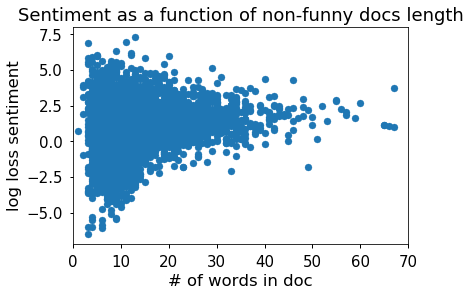

In [41]:
plt.scatter(not_funny['doc_length'], not_funny['sentiment'])
plt.xlabel("# of words in doc")
plt.xlim(0, 70)
plt.title("Sentiment as a function of non-funny docs length")
plt.savefig('sentiment vs length')
plt.ylabel("log loss sentiment")

In [42]:
#length of original dataset2_crowdtruth.csv == 22175 rows
# tookout all duplicates and the "Iasanamericanhavediscoveredanewwaytobel..." row
#Rebalanced  the number of non-funny examples to match that of funny ones
print("working_data/dataset2_crowdtruth_working.csv comprises ", len(jokes), "documents")


working_data/dataset2_crowdtruth_working.csv comprises  10868 documents


In [43]:
# check variance balance among the two classes

print("Variance of funny:", "{:.2f}".format(funny["sentiment"].var()))
print("Variance of not_funny:", "{:.2f}".format(not_funny["sentiment"].var()))
print("\n")
print("Test for homogeneity of variance of sentiment scores between the two classes:")
print(stats.levene(funny['sentiment'], not_funny['sentiment']))

Variance of funny: 1.47
Variance of not_funny: 2.85


Test for homogeneity of variance of sentiment scores between the two classes:
LeveneResult(statistic=448.787179929513, pvalue=1.2290925047070997e-97)


In [44]:
not_funny[:5]

,text,funny,not_funny,sentiment,doc_length
0,"left luggage , also luggage storage or bag storage , is a place where one can temporarily store one 's luggage so as to not have to carry it.",0,1,1.012085,27
1,"their name comes from the title of the the flaming lips album , hit to death in the future head.",0,1,0.363406,19
2,the lyside sulphur can grow from egg to adult in as little as 13 days.,0,1,0.438314,15
3,istanbul suicide bomber entered turkey as a migrant: turkish pm,0,1,-0.977825,10
4,"both describe god as the one divine person , jesus christ , who has a divine soul of love , divine mind of truth , and divine body of activity.",0,1,4.312441,26


Text(0.5,0,'Class (funny, not funny)')

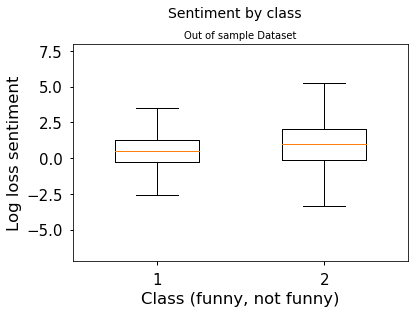

In [59]:
# df2 = df_cmb[df_cmb['DRG'].isin(top)]
# df2 = np.log(df2.pivot(columns='DRG', index=df2.index)['Average Covered Charges'])
# df2.boxplot()
plt.boxplot([funny['sentiment'], not_funny['sentiment']], widths = .5)
plt.suptitle('Sentiment by class',fontsize=14,y=1.01)
plt.title('Out of sample Dataset',fontsize=10)
plt.ylabel('Log loss sentiment')
plt.xlabel('Class (funny, not funny)')

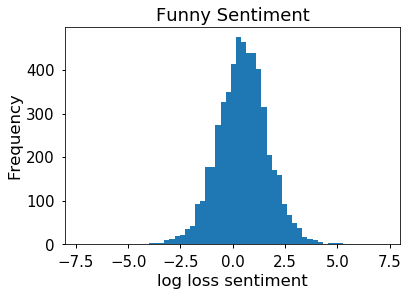

In [45]:
# plot out the sentiment scores by class to look for normality

funny['sentiment'].plot(kind="hist", title="Funny Sentiment", bins=50)
plt.xlabel("log loss sentiment")
plt.xlim(-8, 8)
plt.savefig('funny_sentiment')

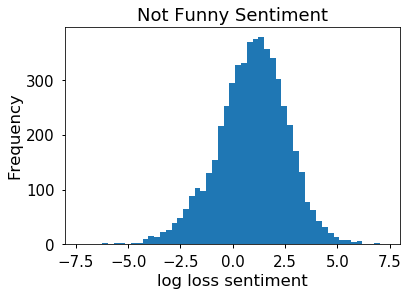

In [46]:
not_funny['sentiment'].plot(kind="hist", title="Not Funny Sentiment",bins=50)
plt.xlabel("log loss sentiment")
plt.xlim(-8, 8)
plt.savefig('not_funny_sentiment')

In [47]:
#take the average of the sentiment scores for each class
# maybe we want to use a different loss measurement?
print("Mean average of log loss sentiment for funny class", "{:.2f}".format(funny['sentiment'].mean()))
print("Mean average of log loss sentiment for not funny class", "{:.2f}".format(not_funny['sentiment'].mean()))

Mean average of log loss sentiment for funny class 0.47
Mean average of log loss sentiment for not funny class 0.91


In [50]:
#check the stdev of the two classes
print("Mean average of log loss sentiment for funny class", "{:.2f}".format(funny['sentiment'].std()))
print("Mean average of log loss sentiment for not funny class", "{:.2f}".format(not_funny['sentiment'].std()))

Mean average of log loss sentiment for funny class 1.21
Mean average of log loss sentiment for not funny class 1.69


In [49]:
# distributions are close to normal, but of unequal variance
# run a Welch's 2 sided t-test for unequal variance to see if the distributions are indeed different
# scipy.stats.ttest_ind(a, b, axis=0, equal_var=False)
# https://pythonfordatascience.org/welch-t-test-python-pandas/

print(stats.ttest_ind(funny['sentiment'], not_funny['sentiment'],equal_var = False))

Ttest_indResult(statistic=-15.614538457530672, pvalue=2.5812579648824968e-54)


In [33]:
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
        
welch_dof(funny['sentiment'], not_funny['sentiment'])

Welch-Satterthwaite Degrees of Freedom= 9869.2794


### To Do: ###
1.) EDA/examples for paper:
Sort funny and not_funny, take subsets from the top, middle and bottom
compare the actual language as to most positive, most negative (see below)

2.) Hypothesis: Changing the most sentient words will change the funniness of the document.
Measure sentiment for a given sentence, select the most neg/pos word accordingly, switch it with a synonym (of opposite sentiment by building out a synonym list for each word in the vocab with sentiment scored on each word), calculate the new sentiment score for the sentence, and measure the difference in funniness using the CNN.

In [35]:
#sort values of the two dataframes
sort_funny = funny.sort_values('sentiment')

In [37]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
sort_funny

,text,funny,not_funny,sentiment
7837,ignoranus: an ignorant butthole.,1,0,-5.711989
9204,tired apostrophes risk falling into a comma.,1,0,-5.318607
6643,humpty dumpty died a crack head.,1,0,-4.948873
8697,pedophiles are fucking immature assholes,1,0,-4.584768
8633,odd? i'm completely whacked.,1,0,-4.334049
7978,ketamine - just say neigh.,1,0,-4.048620
6397,headline: suicidal twin accidentally kills sister,1,0,-3.914906
5456,"""criminal lawyer"" is redundant.",1,0,-3.873816
10636,why don't cannibals eat divorced women? they're bitter.,1,0,-3.811795
8759,rap: retards attempting poetry,1,0,-3.730460


### Analysis ###
The sentiment scores of funny and not_funny classes have statistically significant different distributions, however this is a given with >14000 degrees of freedom.  The shape of the distributions is pretty similar, and absolute difference in log loss is only .5 logs, which does not seem large, as the variances are >1.5, meaning the funny class is slightly less positive than the not_funny class.

## Accuracy of using average sentiment score

In [67]:
#measure accuracy of the classifier by manually scoring 100 docs for sentiment (-1 for negative, 0 for neutral, 1 for positive) 


"# How many sides does a sphere have? Two - inside and outside"
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
score_samp = jokes.sample(300)
score_samp.to_csv("score_sample.csv")

In [68]:
# Manually score the sample (-1 for negative, 0 for neutral, 1 for positive) in "sent_bin" and reimport to analyze

sent_score = pd.read_csv('data/score_sample_binary.csv')

In [112]:
sent_score


,Unnamed: 0,text,sent_bin,funny,not_funny,sentiment,doc_length,abs_diff,correct,check_abs
0,3387,top twitter executives to leave company:,0,0,1,3.488584,6,3.488584,0.0,0.0
1,1678,many ships and lives were reported lost.,-1,0,1,1.213964,7,2.213964,0.0,NaN
2,5,the name `` gulf of california '' predominates on most maps in english today.,0,0,1,1.852806,12,1.852806,0.0,0.0
3,8523,my wife has left me because she says i keep treating her like a pet. she'll be back when she's hungry.,-1,1,0,0.713994,23,1.713994,0.0,NaN
4,6617,"how many sound technicians does it take to screw in a lightbulb? one two, one two",1,1,0,1.506934,16,0.506934,1.0,NaN
5,10116,what's the difference between a canadian hockey player and an iraqi woman? the hockey player takes a shower after three periods.,-1,1,0,0.990201,22,1.990201,0.0,NaN
6,3137,guide dogs are assistance dogs trained to lead blind and vision impaired people around obstacles.,0,0,1,2.849195,15,2.849195,0.0,0.0
7,2854,he is best known for his time spent with extreme championship wrestling and world wrestling entertainment where he was a fourteen time hardcore champion and a two time ecw champion.,1,0,1,2.415469,30,1.415469,1.0,NaN
8,23,california lethal injection plan spurs capital punishment fight,-1,0,1,-1.147974,8,0.147974,1.0,NaN
9,9117,the worst thing about owls is the way that they can maintain eye contact when you put them in a microwave.,-1,1,0,1.581023,21,2.581023,0.0,NaN


In [111]:
#measure how many the classifier gets right assuming neutral sentiment is in range [-1,1]
sent_score.loc[(sent_score["sent_bin"] == 1) & (sent_score.sentiment > .5) , 'correct'] = 1
sent_score.loc[(sent_score["sent_bin"] == 1) & (sent_score.sentiment < .5) , 'correct'] = 0
sent_score.loc[(sent_score["sent_bin"] == -1) & (sent_score.sentiment < -.5) , 'correct'] = 1
sent_score.loc[(sent_score["sent_bin"] == -1) & (sent_score.sentiment > -.5) , 'correct'] = 0
sent_score.loc[(sent_score["sent_bin"] == 0) & (sent_score.abs_diff <= .5) , 'correct'] = 1
sent_score.loc[(sent_score["sent_bin"] == 0) & (sent_score.abs_diff >= .5) , 'correct'] = 0


In [113]:
# Taking the average sentiment of the document, the sentiment classifier is accurate about 35% of the time
sent_score.correct.sum()

40.0

In [110]:
sent_score.sentiment.mean()

0.8927066778354427

## Testing out different versions of apostrophes results in differing sentiment scores ##

In [130]:
# old way, do not run
# calculate sentiment using text_to_sentiment()
jokes["sentiment"] = jokes.apply(lambda x: text_to_sentiment(x['text']), axis=1)
#jokes["sentiment"] = jokes['text'].map(text_to_sentiment)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


KeyError: ("None of [['iasanamericanhavediscoveredanewwaytobelazyandthatisusingnospacebar']] are in the [index]", 'occurred at index 14314')

In [199]:
text_to_sentiment("What's Gordon Ramsay's least favorite movie? IT'S FROOOOOOOZZZZEEEN")

['what', 's', 'gordon', 'ramsay', 's', 'least', 'favorite', 'movie', 'it', 's', 'frooooooozzzzeeen']
          sentiment
what       1.671826
s         -0.122460
gordon    -1.892472
ramsay    -2.713721
s         -0.122460
least      2.166536
favorite   7.262349
movie     -0.607144
it         2.349368
s         -0.122460


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


0.7869362116056201

In [89]:
 text_to_sentiment("What Gordon Ramsay least favorite movie? IT FROOOOOOOZZZZEEEN")

['what', 'gordon', 'ramsay', 'least', 'favorite', 'movie', 'it', 'frooooooozzzzeeen']
          sentiment
what       1.671826
gordon    -1.892472
ramsay    -2.713721
least      2.166536
favorite   7.262349
movie     -0.607144
it         2.349368


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


1.1766774584164532

In [90]:
 text_to_sentiment("What is Gordon Ramsay least favorite movie? IT iS FROOOOOOOZZZZEEEN")

['what', 'is', 'gordon', 'ramsay', 'least', 'favorite', 'movie', 'it', 'is', 'frooooooozzzzeeen']
          sentiment
what       1.671826
is         3.907564
gordon    -1.892472
ramsay    -2.713721
least      2.166536
favorite   7.262349
movie     -0.607144
it         2.349368
is         3.907564


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


1.7835411194177473

In [71]:
text_to_sentiment('''What's a police officers favorite console? Wii U Wii U Wii U Wii U. Edit: Gee Wilikers Batman I've got 151 upvotes yayyyyyy. :D''')

['what', 's', 'a', 'police', 'officers', 'favorite', 'console', 'wii', 'u', 'wii', 'u', 'wii', 'u', 'wii', 'u', 'edit', 'gee', 'wilikers', 'batman', 'i', 've', 'got', '151', 'upvotes', 'yayyyyyy', 'd']
          sentiment
what       1.671826
s         -0.122460
a         -0.594163
police   -11.041842
officers  -4.880302
favorite   7.262349
console    0.049386
wii        1.741504
u          0.802388
wii        1.741504
u          0.802388
wii        1.741504
u          0.802388
wii        1.741504
u          0.802388
edit      -1.323025
gee       -1.598551
batman    -2.937629
i          0.334835
ve         1.751480
got       -1.182238
151       -1.510992
upvotes    4.823927
yayyyyyy   1.319053
d         -4.490601


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


-0.09173515818360652

In [88]:
text_to_sentiment("my name is tyrone jackson")

['my', 'name', 'is', 'tyrone', 'jackson']
         sentiment
my        0.163064
name     -0.941921
is        3.907564
tyrone   -4.810358
jackson  -0.510613


-0.4384529297797027

In [87]:
text_to_sentiment("my name is wyatt anderson")

['my', 'name', 'is', 'wyatt', 'anderson']
          sentiment
my         0.163064
name      -0.941921
is         3.907564
wyatt      1.195736
anderson   0.745451


1.0139787310210078